# Using Amazon SageMaker Automatic Model Tuning to Optimize Portfolio Value
### by Scott Gregoire, Ph.D. and Veronika Megler, Ph.D.

## Table of Contents

1. [Introduction](#introduction)
1. [Background and Solution Overview](#background)  
1. [Training Model](#train)
1. [Analyzing Performance (Part 1)](#performance_one)
1. [Determining the Optimal Classification Threshold](#hpo)
1. [Analyzing Performance (Part 2)](#performance_two)
1. [Adjusting the Optimal Threshold Based Upon Additional Business Considerations](#adjustment)
1. [Conclusion](#conclusion)

## Introduction<a id='introduction'></a>  

Financial institutions that extend credit face the dual tasks of evaluating the credit risk associated with each loan application and of determining a threshold that defines the level of risk they are willing to take on. The evaluation of credit risk is a familiar application of Machine Learning (ML) classification models. The determination of a classification threshold, though, is oftentimes treated as a secondary concern and set in an ad-hoc, unprincipled manner. As a result, institutions may be creating underperforming portfolios and leaving risk-adjusted return on the table.

In this blog post, we describe how to use Amazon SageMaker automatic model tuning to determine the classification threshold that maximizes the portfolio value of a lender choosing which subset of borrowers to extend credit to. More generally, we describe a method of choosing an optimal threshold, or set of thresholds, in a classification setting. The method we describe doesn't rely on rules of thumb or generic metrics. It is a systematic and principled method that relies on a business success metric specific to the problem at hand. The method is based upon utility theory and the idea that a rational individual makes decision in such way as to maximize her expected utility, or subjective value. 

In this post, we assume that the lender is attempting to maximize the expected dollar value of her portfolio by choosing a classification threshold that divides loan applications into two groups: those she accepts and lends to, and those she rejects. In other words, the lender is searching over the space of potential threshold values to find the threshold that results in the highest value for the function that describes her portfolio value.

This post uses Amazon SageMaker automatic model tuning to find that optimal threshold. The accompanying [Jupyter notebook](https://github.com/aws-samples/amazon-sagemaker-hyperparameter-tuning-portfolio-optimization) demonstrates the code supporting this use case. This is a novel use of the automatic model tuning functionality, which is typically used to choose the hyperparameters that optimize model performance. This post uses it as a general tool to maximize a function over some specific parameter space.

This approach has several advantages over the typical threshold determination approach. Typically, a classification threshold is set (or allowed to default) to 0.5, and this threshold doesn't in fact generate the maximum possible result in the majority of use cases. The approach described here chooses a threshold that generates the maximum possible result for the specific business use case being addressed. In the use case in this post, choosing the optimal threshold in the way we describe increases portfolio value by 2.1%.  

Also, this approach moves beyond using general rules-of-thumb and expert judgment in determining an optimal threshold. It lays out a structured framework that can be systematically applied to any classification problem. Additionally, this approach requires the business to explicitly state its cost matrix, based on the specific actions to be taken on the predictions and their benefits and costs. This evaluation process moves well beyond simply assessing the classification results of the model. This approach can drive challenging discussions in the business, and force differing implicit decisions and valuations onto the table for open discussion and agreement. This drives the discussion from a simple “maximize this value”, to a more informative analysis that allows more complex economic tradeoffs to be made – providing more value back to the business.

## Background and solution overview<a id='background'></a>

Assume that a lender is attempting to construct a portfolio from a pool of potential loans. To tackle this use case, the lender must first assess the credit risk associated with each loan in the pool by calculating a probability of default for each loan; the higher the probability of default associated with a loan, the higher the credit risk associated with a loan. To calculate a loan's probability of default, the lender uses an ML classification model, such as a logistic regression or random forest.

Given that the lender has estimated a default probability model, how does she choose the threshold that sets the maximum default probability that a loan can have and she be willing to extend the loan? Users of classification models often set the value of a threshold to the conventional default value of 0.5. Even if they do attempt to set a use case-specific threshold, they do so based upon maximizing some threshold-based metric such as precision or recall. One issue with these metrics is that they ignore certain parts of the discrete outcomes described in the classification matrix. For example, precision overlooks true and false negative outcomes. Additionally, these metrics do not incorporate the dollar costs and benefits associated with each cell of the classification matrix. For example, in the case we examine in this post, the interest rate and loss given a default associated with each loan would be ignored in the calculation of typical threshold-based measures. This situation is less than ideal because, ultimately, what a business values is not the precision or recall of its model, but the dollar value of the incremental profit from using a specific model and threshold.

Therefore, instead of using a generic metric, it is likely more profitable and meaningful to the business to design a threshold-based metric that captures the cost and benefit structure of the specific business use case at hand. The lender we describe in this post is deciding whether to lend or not to set of borrowers. Therefore, a metric that incorporates the expected interest earned and losses from each loan given a predicted probability of default is much more relevant to the business and its decision-making process than some generic metric such as precision or recall. Specifically, the portfolio value metric that we define classifies each loan into one of four buckets: True Positive (TP), False Negative (FN), True Negative (TN), and False Positive (FP); and then calculates the value of each bucket of loans using the following guidelines:

       TP value = -Fixed_Cost  
       FN value = -Fixed_Cost - Loss_Given_Default * Outstanding_Principal_Balance  
       TN value = -Fixed_Cost + Interest_Rate * Outstanding_Principal_Balance  
       FP value = -Fixed_Cost 

* Fixed_Cost captures the costs associated with processing a loan whether it is approved or not 
* Outstanding_Principal_Balance is the principal remaining at the time of default or full repayment
* Interest_Rate is a borrower-specific rate that is set based upon the probability of default associated with a specific loan application plus the expected return desired by the lender; 
* Loss_Given_Default is the proportion of principal expected to be lost if a loan defaults. 

To calculate the total value of a specific bucket of loans, the value of all loans is summed. This total is what the lender is attempting to maximize by choice of a threshold.

Once the lender has clearly defined a quantitative measure of portfolio value, she must then choose the threshold that maximizes that measure. We use Amazon SageMaker automatic model tuning to find the optimal threshold. Amazon SageMaker automatic model tuning is a powerful tool for not only tuning the hyperparameters of an ML model, but also for maximizing an arbitrary function. In this case, we use automatic model tuning in two ways:
* Finding the choice of a threshold that maximizes the lender's portfolio value.
* Mapping out the relationship between threshold and portfolio value more generally.

Understanding the relationship between the threshold choice and portfolio value allows us to more fully understand the economic trade-offs of increasing or decreasing the threshold. This is important as lenders frequently want to consider additional goals beyond simply maximizing the dollar value of their portfolio. Some lenders have idiosyncratic, secondary goals. For example, a lender may want to maximize her portfolio value while also placing emphasis on lending to a certain sector of the economy or to a certain subgroup of the overall population. Knowing how the value of portfolio changes when the threshold moves allows the lender to set a threshold in reasonable manner that addresses both her primary goal of portfolio maximization and her additional secondary goals.

We make several assumptions in this work. We assume that the lender has access to the capital necessary to extend all the loans associated with default probabilities below a chosen threshold. The problem is unconstrained in that sense. Additionally we assume that if a loan is approved, the applicant accepts the terms of the loan no matter what interest rate the lender offers. Lastly, we assume that the lender is risk-neutral, that is, we assume that the lender's utility function is the identity function. In other words, the utility that a lender gains from a certain portfolio value is equal to the portfolio value itself.

Sources:

Friedman, Milton, and L. J. Savage. “The Utility Analysis of Choices Involving Risk.” Journal of Political Economy 56, no. 4 (1948): 279–304.

<a id='data_source'></a>
Data sourced from: 
Li, Min, Amy Mickel, and Stanley Taylor. “‘Should This Loan Be Approved or Denied?’: A Large Dataset with Class Assignment Guidelines.” Journal of Statistics Education 26, no. 1 (January 2, 2018): 55–66. https://doi.org/10.1080/10691898.2018.1434342.

Metz, Charles E. “Basic Principles of ROC Analysis.” Seminars in Nuclear Medicine 8, no. 4 (October 1978): 283–98. https://doi.org/10.1016/S0001-2998(78)80014-2

Wu, Yirong, Craig K. Abbey, Xianqiao Chen, Jie Liu, David C. Page, Oguzhan Alagoz, Peggy Peissig, Adedayo A. Onitilo, and Elizabeth S. Burnside. “Developing a Utility Decision Framework to Evaluate Predictive Models in Breast Cancer Risk Estimation.” Journal of Medical Imaging 2, no. 4 (October 2015). https://doi.org/10.1117/1.JMI.2.4.041005.

Zadrozny, Bianca, and Charles Elkan. “Learning and Making Decisions When Costs and Probabilities Are Both Unknown,” 204–13. ACM Press, 2001. https://doi.org/10.1145/502512.502540.

Veronika Megler and Scott Gregoire. “[Training models with unequal economic error costs using Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/training-models-with-unequal-economic-error-costs-using-amazon-sagemaker/),“ AWS Machine Learning Blog, 18 Sept 2018. 

In the remainder of this section, we:
* Import library code used in this notebook
* Import the data
* Pre-process the data
* Split it into training and test sets
* Save the data to S3

In the next sections we use this data to walk through the following steps:

1. In [Training Model](#train), we train a Random Forest classifier using the Amazon SageMaker built-in Scikit-learn Estimator, using a default threshold.
1. We analyze the performance of the initial model in [Analyzing Performance (Part 1)](#performance_one).
1. [Determining the Optimal Classification Threshold](#hpo) walks through using Automatic Model Tuning to find the threshold that gives the highest portfolio value.
1. [Analyzing Performance (Part 2)](#performance_two) shows how the new portfolio performance compares to the portfolio that uses the default threshold.
1. [Adjusting the Optimal Threshold Based Upon Additional Business Considerations](#adjustment) walks through how additional business goals can be incorporated, while analyzing their impact on the portfolio.

### Importing Libraries<a id='libraries'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.externals.joblib import load
import sagemaker
from sagemaker.sklearn import SKLearn
import boto3
import os 
import warnings

import helpers

In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
%matplotlib inline
pd.options.display.max_colwidth = -1
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
pd.options.display.max_info_columns = 200

In [4]:
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

A S3 bucket that will contain both the training data and model output is created below. The name of this bucket is a combination of the name of the Docker image created later in this notebook, the region in which this notebook instance is located, and your account number. 

In [5]:
#This is the name that will be associated with the Docker image created in this notebook.
image_name = 'sagemaker-portfolio-value-opt-blog-post'
#This is your account number.
account_id = boto3.client('sts').get_caller_identity().get('Account')
#This is the region in which this notebook instance is located.
region = sagemaker_session.boto_region_name

bucket = image_name + '.' + region + '.' + account_id

print('S3 bucket name: ', bucket)

S3 bucket name:  portfolio-value-optimization-blog-post.us-west-2.911148158337


The S3 bucket named above is created if it doesn't exist already. The same is true for local folders that will hold the training and test data used in this post.

In [6]:
if not boto3.resource('s3').Bucket(bucket).creation_date:
    boto3.resource('s3').Bucket(bucket).create(ACL='private', CreateBucketConfiguration={'LocationConstraint':region})

model_artifacts_s3_location = 's3://{}/artifacts'.format(bucket)

train_data_s3_location = 's3://{}/data/train'.format(bucket)
test_data_s3_location = 's3://{}/data/test'.format(bucket)

datadir = './data'
if not os.path.exists(datadir):
    os.mkdir(datadir)

traindir = './data/train'
if not os.path.exists(traindir):
    os.mkdir(traindir)
testdir = './data/test'
if not os.path.exists(testdir):
    os.mkdir(testdir)

x_train_local_key = traindir + '/x_train.csv'
y_train_local_key = traindir + '/y_train.csv'
x_test_local_key = testdir + '/x_test.csv'
y_test_local_key = testdir + '/y_test.csv'

### Importing the Data<a id='data'></a>

In this section, we download the loan data locally to the Amazon SageMaker notebook instance. 

The data consists of a set of US Small Business Administration (SBA)-guaranteed loans from 1987 to 2014. These are loans extended to US-based small businesses by private banks, though a large percentage of the principal is guaranteed by the US SBA in the event that a borrower defaults. On average, the SBA guarantees about 70% of the principal for each of the loans in this data set. This sizable guarantee offsets much of the credit risk associated with each loan and encourages private banks to extend credit to small business that they might not otherwise extend credit to. For the data itself, and a more detailed description of the data, see the supplementary material of [Li, Mickel, and Taylor](#data_source). You should also read the [license](https://amstat.tandfonline.com/action/showCopyRight?scroll=top&doi=10.1080%2F10691898.2018.1434342#.XUNQjZNKjdQ) associated with the use of this research paper.

In [7]:
data_address = 'https://amstat.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip'

In [8]:
!wget $data_address

--2019-08-08 19:42:58--  https://amstat.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip
Resolving amstat.tandfonline.com (amstat.tandfonline.com)... 104.17.76.237, 104.17.75.237
Connecting to amstat.tandfonline.com (amstat.tandfonline.com)|104.17.76.237|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://amstat.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip?cookieSet=1 [following]
--2019-08-08 19:42:59--  https://amstat.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip?cookieSet=1
Reusing existing connection to amstat.tandfonline.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://amstat.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file/ujse_a_1434342_sm1547.zip [following]
--2019-08-08 19:42:59--  https://amstat.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342/suppl_file

Unzip the data files just downloaded.

In [9]:
zip_file = !ls *.zip
zip_file = zip_file[0]

In [10]:
!unzip -o $zip_file

Archive:  ujse_a_1434342_sm1547.zip
  inflating: JSE #15-091.Loan Documentation_ National SBA.docx  
  inflating: JSE #15-091_Loan documentation_SBA Case final.docx  
  inflating: SBAcase.11.13.17.csv    
  inflating: SBAnational.csv         


Load the full data set located in the SBAnational.csv file.

In [11]:
data_name = 'SBAnational.csv'

In [12]:
data = pd.read_csv(data_name)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
LoanNr_ChkDgt        899164 non-null int64
Name                 899150 non-null object
City                 899134 non-null object
State                899150 non-null object
Zip                  899164 non-null int64
Bank                 897605 non-null object
BankState            897598 non-null object
NAICS                899164 non-null int64
ApprovalDate         899164 non-null object
ApprovalFY           899164 non-null object
Term                 899164 non-null int64
NoEmp                899164 non-null int64
NewExist             899028 non-null float64
CreateJob            899164 non-null int64
RetainedJob          899164 non-null int64
FranchiseCode        899164 non-null int64
UrbanRural           899164 non-null int64
RevLineCr            894636 non-null object
LowDoc               896582 non-null object
ChgOffDate           162699 non-null object
DisbursementDate 

In [14]:
data.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


Our goal is to construct a model that predicts the probability that a specific loan will default, thus the target variable is MIS_Status. MIS_Status takes on two values: "P I F" if a loan has been paid in full, or "CHGOFF" if a loan has defaulted and the bank has taken the resulting loss.

As can be seen below, the target variable is imbalanced -- about 18% of the observations have defaulted. Our approach in dealing with this imbalance is to estimate the model with the data as-is, and then set the decision threshold to optimize the economic value of our credit portfolio.

In [15]:
data['MIS_Status'].value_counts()/data['MIS_Status'].shape[0]

P I F     0.822552
CHGOFF    0.175227
Name: MIS_Status, dtype: float64

### Pre-processing the data<a id='preprocess'></a>

Drop columns that are we believe are unlikely to add predictive power to model.

In [16]:
cols_to_drop = [
    'LoanNr_ChkDgt', #Specific to each loan. Likely not useful in generalizing.
    'Name', #Specific to each loan. Likely not useful in generalizing.
    'City', #Capturing location with State instead of City since City would increase the number of OHE variables by too much.
    'Zip', #Capturing location with State instead of Zip since Zip would increase the number of OHE variables by too much.
    'Bank', #OHE variables based upon Bank would increase variable count by too much.
    'ChgOffDate', #Wouldn't be known at origination.
    'ChgOffPrinGr', #Wouldn't be known at origination.
    'BalanceGross', #Wouldn't be known at origination (if different from GrAppv).
    'DisbursementGross', #Likely wouldn't be known at origination (if different from GrAppv).
    'DisbursementDate', #Likely wouldn't be known at origination.
    'ApprovalDate', #Assuming date of origination doesn't matter, though may be worth investigating.
    'ApprovalFY', #Assuming date of origination doesn't matter, though may be worth investigating.
    'FranchiseCode' #Results in too many OHE variables.
]

In [17]:
data = data.drop(columns=cols_to_drop)

Drop all records that are not completely populated.

In [18]:
print('Number of records dropped: ', data.isnull().any(axis=1).sum())

Number of records dropped:  10743


In [19]:
data = data.dropna(axis=0)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888421 entries, 0 to 899163
Data columns (total 14 columns):
State          888421 non-null object
BankState      888421 non-null object
NAICS          888421 non-null int64
Term           888421 non-null int64
NoEmp          888421 non-null int64
NewExist       888421 non-null float64
CreateJob      888421 non-null int64
RetainedJob    888421 non-null int64
UrbanRural     888421 non-null int64
RevLineCr      888421 non-null object
LowDoc         888421 non-null object
MIS_Status     888421 non-null object
GrAppv         888421 non-null object
SBA_Appv       888421 non-null object
dtypes: float64(1), int64(6), object(7)
memory usage: 101.7+ MB


#### Feature generation

Below, we create several features that [Li, Mickel, and Taylor](#data_source) identified as being important predictors of default.

##### NAICS Classification

Classifying each business according to its 2-digit NAICS code.

NAICS mapping  
  
21	Mining, quarrying, and oil and gas extraction  
11	Agriculture, forestry, fishing and hunting  
55	Management of companies and enterprises  
62	Health care and social assistance  
22	Utilities  
92	Public administration  
54	Professional, scientific, and technical services  
42	Wholesale trade  
31–33	Manufacturing  
81	Other services (except public administration) 
71	Arts, entertainment, and recreation  
72	Accommodation and food services  
44–45	Retail trade  
23	Construction  
56	Administrative/support & waste management/remediation Service  
61	Educational services  
51	Information  
48–49	Transportation and warehousing  
52	Finance and insurance  
53	Real estate and rental and leasing

In [21]:
data['NAICS_abbrev'] = data['NAICS'].astype('str').str[:2]
data = data.drop(columns=['NAICS'])

##### Backed by Real Estate Collateral?

If a loan has a term >= 240 months, then it is required to be backed by Real Estate (see section 4.1.5 of [Li, Mickel, and Taylor](#data_source)). If the term is < 240 months, then the loan is not backed by collateral. We create an indicator that captures this information.

In [22]:
data['Real_Estate'] = (data['Term'] >= 240) + 0

##### Percentage of Principal Guaranteed by SBA

In [23]:
data['SBA_Appv'] = data['SBA_Appv'].str.replace('$','').str.replace(',','').astype('float')
data['GrAppv'] = data['GrAppv'].str.replace('$','').str.replace(',','').astype('float')
data['SBA_Appv_%'] = data['SBA_Appv']/data['GrAppv']

#### Data cleaning

Several variables take on unexpected values. Below we collapse all unexpected values for a given variable into the '0' category. We also map the target variable to 0/1 to create an integer variable as opposed to a string. Lastly, we create One Hot Encoding variables for all categorical variables.

##### RevLineCr

If RevLineCr not equal to Y or N, then set equal to 0.

In [24]:
data['RevLineCr'].value_counts()

N    415876
0    257412
Y    199881
T    15187 
1    23    
R    14    
`    11    
2    6     
C    2     
7    1     
-    1     
4    1     
3    1     
Q    1     
.    1     
A    1     
5    1     
,    1     
Name: RevLineCr, dtype: int64

In [25]:
def fix_revcr(x):
    
    if (x=='N')|(x=='Y'):
        x=x
    else:
        x='0'
    
    return x

In [26]:
data['RevLineCr'] = data['RevLineCr'].map(fix_revcr)

In [27]:
data['RevLineCr'].value_counts()

N    415876
0    272664
Y    199881
Name: RevLineCr, dtype: int64

##### LowDoc

If LowDoc not equal to Y or N, then set equal to 0.

In [28]:
data['LowDoc'].value_counts()

N    777352
Y    107903
0    1237  
C    757   
S    602   
A    495   
R    74    
1    1     
Name: LowDoc, dtype: int64

In [29]:
def fix_lowdoc(x):
    
    if (x=='N')|(x=='Y'):
        x=x
    else:
        x='0'
    
    return x

In [30]:
data['LowDoc'] = data['LowDoc'].map(fix_lowdoc)

In [31]:
data['LowDoc'].value_counts()

N    777352
Y    107903
0    3166  
Name: LowDoc, dtype: int64

##### Mapping Target Variable to Numeric Values

In [32]:
data['MIS_Status'] = data['MIS_Status'].map({'P I F': 0, 'CHGOFF': 1})

In [33]:
data.head()

,State,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,SBA_Appv,NAICS_abbrev,Real_Estate,SBA_Appv_%
0,IN,OH,84,4,2.0,0,0,0,N,Y,0,60000.0,48000.0,45,0,0.80
1,IN,IN,60,2,2.0,0,0,0,N,Y,0,40000.0,32000.0,72,0,0.80
2,IN,IN,180,7,1.0,0,0,0,N,N,0,287000.0,215250.0,62,0,0.75
3,OK,OK,60,2,1.0,0,0,0,N,Y,0,35000.0,28000.0,0,0,0.80
4,FL,FL,240,14,1.0,7,7,0,N,N,0,229000.0,229000.0,0,1,1.00


##### Creating One Hot Encoding indicators for all relevant variables

In [34]:
y = data.pop('MIS_Status')

In [35]:
x = pd.get_dummies(data, columns= ['State', 
                                    'BankState', 
                                    'NewExist',  
                                    'UrbanRural', 
                                    'RevLineCr', 
                                    'LowDoc',
                                    'NAICS_abbrev', 
                                    'Real_Estate'])

In [36]:
x.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 888421 entries, 0 to 899163
Columns: 153 entries, Term to Real_Estate_1
dtypes: float64(3), int64(4), uint8(146)
memory usage: 177.9 MB


### Splitting data into training and test sets

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)

### Saving data to S3

First, save pre-processed training and test sets locally

In [38]:
x_train.to_csv(x_train_local_key, header=True, index=False)
y_train.to_csv(y_train_local_key, header=True, index=False)
x_test.to_csv(x_test_local_key, header=True, index=False)
y_test.to_csv(y_test_local_key, header=True, index=False)

Then upload the processed data to S3 

In [39]:
train_full_upload = sagemaker_session.upload_data(path='data/train', bucket=bucket, key_prefix='data/train')
test_full_upload = sagemaker_session.upload_data(path='data/test', bucket=bucket, key_prefix='data/test')

## Training the model<a id='train'></a>

Now we train a random forest classifier using the Amazon SageMaker built-in Scikit-learn Estimator. We chose a random forest after comparing its performance to both that of a Logistic Regression and a Gradient Boosted Classifier. The Amazon SageMaker built-in estimator allows users to build and deploy custom Scikit-learn models without needing to create and manage a custom Docker container. For more information on how implement models using the built-in Scikit-learn Estimator, see [the Amazon SageMaker Python SDK documentation](https://sagemaker.readthedocs.io/en/stable/using_sklearn.html).

The file estimate_model.py contains the Scikit-Learn model that we train to predict a loan's probability of default. Training this model takes about 10 minutes.

In [38]:
sklearn_script_path = 'estimate_model.py'

model = SKLearn(entry_point=sklearn_script_path,
                role=role,
                py_version='py3',
                framework_version='0.20.0',
                train_instance_count=1,
                train_instance_type='ml.c5.2xlarge',
                output_path=model_artifacts_s3_location,
                sagemaker_session=sagemaker_session)

model.fit({
    'train': train_data_s3_location,
    'test': test_data_s3_location
})

2019-08-08 19:44:27 Starting - Starting the training job...
2019-08-08 19:44:29 Starting - Launching requested ML instances......
2019-08-08 19:45:37 Starting - Preparing the instances for training...
2019-08-08 19:46:22 Downloading - Downloading input data...
2019-08-08 19:46:49 Training - Training image download completed. Training in progress..
2019-08-08 19:46:49,940 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2019-08-08 19:46:49,942 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-08-08 19:46:49,952 sagemaker_sklearn_container.training INFO     Invoking user training script.
2019-08-08 19:46:50,151 sagemaker-containers INFO     Module estimate_model does not provide a setup.py. 
Generating setup.py
2019-08-08 19:46:50,151 sagemaker-containers INFO     Generating setup.cfg
2019-08-08 19:46:50,151 sagemaker-containers INFO     Generating MANIFEST.in
2019-08-08 19:46:50,151 sagemaker-containers INFO     Instal

## Analyzing model performance (Part 1)<a id='performance_one'></a>

For comparison, we create a naïve model, classifying all observations to the majority class, that is, predicting that no loans will default. Does the random forest perform better than the naive model?

We have not yet determined the optimal threshold to classify the prediction of the random forest model into default or non-default classes. Therefore, the only performance metrics available to us to answer the above question are those based upon the predicted class probabilities output by our model. Metrics based on class predictions, for example, accuracy, precision or recall, are dependent on our as-yet-undefined threshold. So to answer this question initially, we compare the log loss of the random forecast and naive models. Log loss calculates how far predicted class probabilities are off from the true labels. Therefore, log loss is metric that can be determined without reference to a threshold.

We will more thoroughly analyze model performance, using the more familiar threshold-based metrics, after we have calculated the optimal threshold.

### Loading model

In order to examine predictions made by the Random Forest that trained above, we load the model artifact that Amazon SageMaker saves to S3.

In [54]:
model_pickle_key = 'artifacts/{}/output/model.tar.gz'.format(model.hyperparameters()['sagemaker_job_name'].replace('"',''))

In [55]:
s3 = boto3.resource('s3')    
s3.Bucket(bucket).download_file(model_pickle_key, 'model.tar.gz')
os.system('tar -xzvf model.tar.gz')
loaded_model = load('random_forest_classifier.pkl')

### Generating model predictions

In [56]:
scaler = StandardScaler().fit(x_train)
x_test_scld = scaler.transform(x_test)

Class probability predictions for the Naive model are:

In [57]:
naive_pred = pd.Series(data=[0]*len(y_test), dtype=np.int8)

Class probability predictions for the Random Forest model are:

In [58]:
random_forest_pred = loaded_model.predict_proba(x_test_scld)
random_forest_pred = random_forest_pred[:,1] #save only default class predictions

### Calculating log loss

Does the random forest perform better than the naive model? 

In [59]:
naive_logloss = log_loss(y_test, naive_pred)
random_forest_logloss = log_loss(y_test, random_forest_pred)

Remember that a smaller log loss indicates a smaller error and better performance. The following output from the model runs shows the results:

In [60]:
print('Naive Log Loss: {:0,.4f}'.format(naive_logloss))
print('Random Forest Log Loss: {:0,.4f}'.format(random_forest_logloss))

Naive Log Loss: 6.1230
Random Forest Log Loss: 0.2039


The answer is yes, the random forest improves on the log loss of the naive model by a significant amount. This implies that the random forest model assigned predicted class probabilities to each observation that are much closer to the truth than the naive model’s predictions.

### Plotting the model predictions

In each of the following plot sets, the top histogram plots the distribution of predicted scores for all actual negatives, that is, the predicted scores for borrowers that do not default. In essence, it represents the score distributions associated with specificity. The bottom histogram plots predicted scores for actual positives, that is, the predicted scores for borrowers that do default, thus representing the score distributions for sensitivity.

The correctly classified observations on each plot are colored blue, and the incorrectly classified observations are colored orange. We use the default threshold value of 0.5 to color these plots. This is the typical threshold used to classify the results of a classification model, chosen without attempting to maximize the user's success—or value—metric.

The threshold choice does not affect the actual predicted scores, shape, or level of the plots, only the coloring. It does, however, effect metric results, including sensitivity, specificity, and most commonly used model performance metrics.

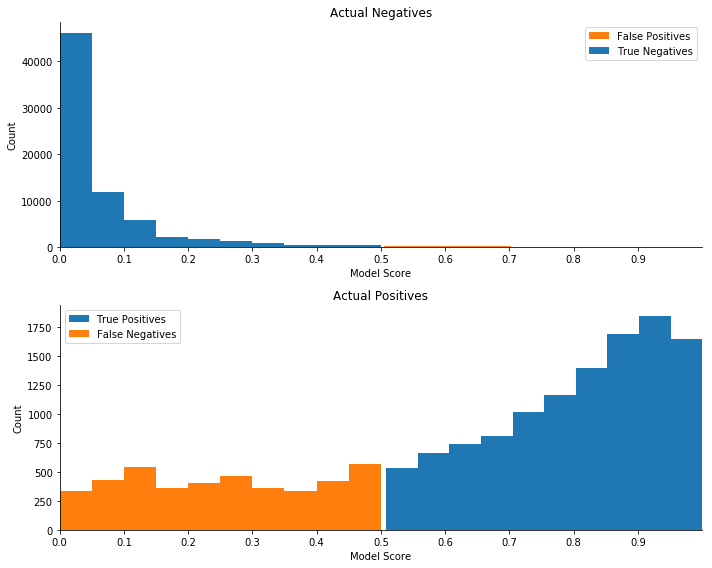

In [61]:
random_forest_positives = random_forest_pred[y_test==1]
random_forest_negatives = random_forest_pred[y_test==0]

helpers.custom_pred_distro(positives=random_forest_positives, negatives=random_forest_negatives, cutoff=0.5, title=None)

These two graph shows that while the scores for the true negatives are clustered close to 0, the scores for the false negatives are distributed relatively evenly from 0 to the current cutoff at 0.5. The dataset doesn’t include data items that would allow strong discrimination between true and false negatives.

This distribution may point to a significant amount of potential income being missed from this portfolio of approved and rejected loans. Using the default threshold score of 0.5 for approving a loan is not optimal for this dataset. Let's explore how the portfolio value can be further increased by optimizing the threshold.

### Calculating portfolio value based upon a 0.5 threshold

Lastly, we calculate the portfolio values for the naive model and the random forest model based upon a 0.5 threshold as reference points to determine if in fact choosing an optimal threshold increases the value of the loan portfolio.

In [62]:
#Calculating the predicted target classes for the test set if we assume a threshold of 0.5
random_forest_pred_discrete_point_five = pd.Series((random_forest_pred > 0.5) + 0, dtype=np.int8)

naive_portfolio_value_obj = helpers.calc_portfolio_value(x_test=x_test, y_test=y_test, y_prediction=naive_pred, y_prediction_discrete=naive_pred, threshold=0.5, fixed_cost=100, desired_return=0.05)
naive_max_portfolio_value = naive_portfolio_value_obj[0]

#Calculating the Portfolio Value given a threshold of 0.5
random_forest_portfolio_value_point_five_obj = helpers.calc_portfolio_value(x_test=x_test, y_test=y_test, y_prediction=random_forest_pred, y_prediction_discrete=random_forest_pred_discrete_point_five, threshold=0.5, fixed_cost=100, desired_return=0.05)
random_forest_portfolio_value_point_five = random_forest_portfolio_value_point_five_obj[0]

Note that any non-zero threshold results in the same portfolio value in the Naive model since the probability of default for all loans is 0.

In [63]:
print('Naive Portfolio Value (Threshold=0.5): ${:0,.0f}'.format(naive_max_portfolio_value).replace('$-','-$'))
print('Random Forest Portfolio Value (Threshold=0.5): ${:0,.0f}'.format(random_forest_portfolio_value_point_five).replace('$-','-$'))

Naive Portfolio Value (Threshold=0.5): $203,498,022
Random Forest Portfolio Value (Threshold=0.5): $823,674,285


## Determining the optimal classification threshold with automatic model tuning<a id='hpo'></a>

Can we do better, by choosing a different threshold? And how do we go about finding the optimal threshold to balance the lender's risk and reward?

In this section, the optimal threshold for classifying loans as default or non-default is determined using the Amazon SageMaker automatic model tuning functionality. The optimal threshold is the threshold that maximizes the user's value metric. In this case, the metric that is being maximized is total portfolio value, as described above.  

To use Amazon SageMaker automatic model tuning to optimize the classification threshold, we construct a Docker container that takes the random forest model trained previously and the test set as input. Given a threshold, the container calculates the total value of the portfolio if the lender extended all loans classified as non-default, and the borrower accepted them. Amazon SageMaker automatic model tuning generates a range of thresholds between 0 and 1 and chooses the threshold that maximizes portfolio value. 

For more information on Automatic Model Tuning using Amazon SageMaker, please refer to the [Amazon SageMaker documentation](#https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)

### Building the container image<a id='container'></a>

Executing the line of code below builds the Docker image and pushes the image to Amazon Elastic Container Registry (ECR). This Docker image contains the code that calculates the portfolio value given a trained model and a specific threshold.

The "image_name" defined at the top of this notebook is the name that will be assigned to the repository in ECR that contains this image.

In [64]:
! ./build_and_push.sh {image_name}

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  2.289GB
Step 1/10 : FROM continuumio/miniconda3:4.6.14
 ---> 6b5cf97566c3
Step 2/10 : MAINTAINER Scott Gregoire <sggregoi@amazon.com>
 ---> Using cache
 ---> 4085cbc852bd
Step 3/10 : RUN apt-get -y update
 ---> Using cache
 ---> d4fdadd4310c
Step 4/10 : RUN conda install pandas==0.24.2 scikit-learn==0.20.0 numpy scipy
 ---> Using cache
 ---> cacf286ca011
Step 5/10 : RUN pip install boto3==1.9.159
 ---> Using cache
 ---> d7b732497d8a
Step 6/10 : ENV PYTHONUNBUFFERED=TRUE
 ---> Using cache
 ---> dfbdb05fe381
Step 7/10 : ENV PYTHONDONTWRITEBYTECODE=TRUE
 ---> Using cache
 ---> 2fd4874a6472
Step 8/10 : ENV PATH="/opt/program:${PATH}"
 ---> U

In [65]:
account = sagemaker_session.boto_session.client('sts').get_caller_identity()['Account']
region = sagemaker_session.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, image_name)

### Running the Automatic Model Tuning job<a id='job'></a>

To use the Amazon SageMaker automatic model tuning feature, we first need to define the metric that we want Amazon SageMaker to optimize, the parameter space we want the tuning job to search over to find the optimal threshold, and any additional metrics we want calculated during the tuning job.

First, we define the metrics we wish each job to return. As we'd like to explore the characteristics of the portfolio generated in some detail, we generate a list of metrics that describe the approved and rejected loans. These metrics are reported from each training job that runs via automatic model tuning. The additional metrics allow us to explore the characteristics of the maximized portfolio.

Of all the metrics we define, we need to specify which metric the automatic model tuning job should use to optimize the threshold. We do this by specifying the objective_metric_name in the HyperparameterTuner object below. In the same object, we must specify the hyperparameter range we would like to search over; in this case, we specify all continuous values between 0 and 1 to search over for the optimal threshold.

Lastly, we specify that we want Amazon SageMaker to run 200 individual training jobs. Each of these 200 training jobs uses a specific threshold value to calculate a different portfolio value. After Amazon SageMaker calculates the 200 portfolio values, each based upon a different threshold, it outputs the threshold that maximizes portfolio value.

In [66]:
objective_metric_name = 'portfolio_value'
objective_type = 'Maximize' #Maximize or Minimize
base_tuning_job_name = 'hpo-threshold'

metric_definitions = [
                      {'Name': 'portfolio_value',
                       'Regex': 'portfolio_value: (\\S+)'},
    
                      {'Name': 'accuracy',
                       'Regex': 'accuracy: (\\S+)'},
                        
                      {'Name': 'approved_loan_total',
                       'Regex': 'approved_loan_total: (\\S+)'},
                      {'Name': 'approved_loan_cnt',
                       'Regex': 'approved_loan_cnt: (\\S+)'},
                      {'Name': 'approved_loan_25',
                       'Regex': 'approved_loan_25: (\\S+)'},
                      {'Name': 'approved_loan_50',
                       'Regex': 'approved_loan_50: (\\S+)'},
                      {'Name': 'approved_loan_75',
                       'Regex': 'approved_loan_75: (\\S+)'},

                      {'Name': 'rejected_loan_total',
                       'Regex': 'rejected_loan_total: (\\S+)'},
                      {'Name': 'rejected_loan_cnt',
                       'Regex': 'rejected_loan_cnt: (\\S+)'},
                      {'Name': 'rejected_loan_25',
                       'Regex': 'rejected_loan_25: (\\S+)'},
                      {'Name': 'rejected_loan_50',
                       'Regex': 'rejected_loan_50: (\\S+)'},
                      {'Name': 'rejected_loan_75',
                       'Regex': 'rejected_loan_75: (\\S+)'},
    
                      {'Name': 'approved_interest_rate_cnt',
                       'Regex': 'approved_interest_rate_cnt: (\\S+)'},
                      {'Name': 'approved_interest_rate_25',
                       'Regex': 'approved_interest_rate_25: (\\S+)'},
                      {'Name': 'approved_interest_rate_50',
                       'Regex': 'approved_interest_rate_50: (\\S+)'},
                      {'Name': 'approved_interest_rate_75',
                       'Regex': 'approved_interest_rate_75: (\\S+)'},
    
                      {'Name': 'tn',
                       'Regex': 'TN: (\\S+)'},
                      {'Name': 'fp',
                       'Regex': 'FP: (\\S+)'},
                      {'Name': 'fn',
                       'Regex': 'FN: (\\S+)'},
                      {'Name': 'tp',
                       'Regex': 'TP: (\\S+)'}      
                     ]

#Specify type of loss function with which to train the model. Specify false negative and false negative costs
#if using a custom loss function

hyperparameters_static = {
            "model_pickle_bucket": bucket, 
            "model_pickle_key": model_pickle_key 
        }

hpo_model = sagemaker.estimator.Estimator(image_name=image,
                    role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c5.2xlarge',
                    output_path=model_artifacts_s3_location,
                    hyperparameters=hyperparameters_static,
                    sagemaker_session=sagemaker_session)

hyperparameter_ranges = {
    'threshold': sagemaker.tuner.ContinuousParameter(0,1)
}

tuner = sagemaker.tuner.HyperparameterTuner(hpo_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            objective_type=objective_type,
                            max_jobs=200,
                            max_parallel_jobs=10,
                            strategy='Random', #Options here are Random or Bayesian
                            base_tuning_job_name=base_tuning_job_name)

tuner.fit({
    'train': train_data_s3_location,
    'test': test_data_s3_location
})

In [69]:
hpo_job_name = tuner.latest_tuning_job.job_name
print("Job name is: " + hpo_job_name)

Job name is: hpo-threshold-190808-1957


In [71]:
print("Status is: " + boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus'])

Status is: Completed


Wait until the job status is "Completed" (about one hour). You can rerun the cell above to check status.

## Analyzing model performance (part 2)<a id='performance_two'></a>

In this section, we continue analyzing the performance of the Naive and Random Forest models, but now that we have determined the optimal threshold, we are able to incorporate threshold-based metrics in the analysis.

### Collecting the Automatic Model Tuning job metrics

First, we collect the metrics and metadata from the HPO job and merge the information into a single dataframe.

In [72]:
hpo_metrics = helpers.get_hpo_metrics(hpo_job_name)
hpo_hyperparameters = helpers.get_hyperparameters(hpo_job_name)

hpo = hpo_metrics.merge(hpo_hyperparameters, how='inner', left_index=True, right_on='TrainingJobName')
hpo = hpo.drop(columns='portfolio_value_x')
hpo = hpo.rename(columns={'portfolio_value_y':'portfolio_value'})

hpo['threshold'] = round(hpo['threshold'], 3)

50  Training Jobs loaded.
100  Training Jobs loaded.
150  Training Jobs loaded.
200  Training Jobs loaded.


Calculating the return for each portfolio, that is, the net portfolio value divided by the total credit lent.

In [73]:
hpo['portfolio_return'] = hpo['portfolio_value']/hpo['approved_loan_total']

In [99]:
hpo.sort_values(by='portfolio_value', ascending=False).head(10)

,accuracy,approved_interest_rate_25,approved_interest_rate_50,approved_interest_rate_75,approved_interest_rate_cnt,approved_loan_25,approved_loan_50,approved_loan_75,approved_loan_cnt,approved_loan_total,fn,fp,rejected_loan_25,rejected_loan_50,rejected_loan_75,rejected_loan_cnt,rejected_loan_total,tn,tp,TrainingJobName,portfolio_value,threshold,portfolio_return,threshold_2_digit
98,0.935932,0.05,0.057500,0.076087,73114.0,43000.0,100000.0,253725.0,73114.0,1.570100e+10,2899.0,2878.0,23000.0,45000.0,100000.0,15729.0,1.541148e+09,70215.0,12851.0,hpo-threshold-190808-1957-102-2cc59551,841421888.0,0.359,0.053590,0.35
117,0.935932,0.05,0.057500,0.076087,73114.0,43000.0,100000.0,253725.0,73114.0,1.570100e+10,2899.0,2878.0,23000.0,45000.0,100000.0,15729.0,1.541148e+09,70215.0,12851.0,hpo-threshold-190808-1957-083-afccf0e4,841421888.0,0.358,0.053590,0.35
41,0.935932,0.05,0.057143,0.076087,72889.0,43000.0,100000.0,254000.0,72889.0,1.566342e+10,2825.0,3029.0,23500.0,48000.0,100000.0,15954.0,1.578729e+09,70064.0,12925.0,hpo-threshold-190808-1957-159-587c4c83,840656704.0,0.349,0.053670,0.34
36,0.935932,0.05,0.057143,0.076087,72888.0,43000.0,100000.0,254000.0,72888.0,1.566341e+10,2825.0,3030.0,23500.0,48000.0,100000.0,15955.0,1.578734e+09,70063.0,12925.0,hpo-threshold-190808-1957-164-3e1d3949,840654976.0,0.342,0.053670,0.34
31,0.935932,0.05,0.057143,0.076087,72888.0,43000.0,100000.0,254000.0,72888.0,1.566341e+10,2825.0,3030.0,23500.0,48000.0,100000.0,15955.0,1.578734e+09,70063.0,12925.0,hpo-threshold-190808-1957-169-ceecb349,840654976.0,0.344,0.053670,0.34
51,0.935932,0.05,0.057732,0.078571,74145.0,42400.0,100000.0,252000.0,74145.0,1.591500e+10,3314.0,2262.0,20000.0,40650.0,92325.0,14698.0,1.327143e+09,70831.0,12436.0,hpo-threshold-190808-1957-149-5a6520ed,840528832.0,0.405,0.052814,0.40
13,0.935932,0.05,0.057732,0.078571,74144.0,42475.0,100000.0,252000.0,74144.0,1.591499e+10,3314.0,2263.0,20000.0,40600.0,92250.0,14699.0,1.327158e+09,70830.0,12436.0,hpo-threshold-190808-1957-187-4f6257db,840522496.0,0.400,0.052813,0.40
193,0.935932,0.05,0.057732,0.078571,74144.0,42475.0,100000.0,252000.0,74144.0,1.591499e+10,3314.0,2263.0,20000.0,40600.0,92250.0,14699.0,1.327158e+09,70830.0,12436.0,hpo-threshold-190808-1957-007-680a2308,840522496.0,0.402,0.052813,0.40
2,0.935932,0.05,0.057732,0.077273,73735.0,42687.5,100000.0,253000.0,73735.0,1.583827e+10,3138.0,2496.0,20300.0,45000.0,99127.0,15108.0,1.403881e+09,70597.0,12612.0,hpo-threshold-190808-1957-198-6e7e67a5,840333760.0,0.387,0.053057,0.38
63,0.935932,0.05,0.057732,0.077273,73734.0,42700.0,100000.0,253000.0,73734.0,1.583824e+10,3138.0,2497.0,20300.0,45000.0,99100.0,15109.0,1.403906e+09,70596.0,12612.0,hpo-threshold-190808-1957-137-e30b6471,840323904.0,0.383,0.053057,0.38


While many of the reported metrics are the same for each of these first few HPO jobs, the threshold used varies (scroll to the right). As we move down the list, the portfolio_value, approved_ and rejected_load_totals, and the true and false negatives and positives begin to shift.

### Plotting the Automatic Model Tuning job results

The flatness in these graphs is due to the precision of predictions, which is a function of the number of trees in the random forest model. Since there are 100 tree in the random forest model, the precision of the predictions is 2 decimal places. This implies that all thresholds, for example, >.32 and <=.33 give the same result.  

In [75]:
optimal_threshold = hpo.sort_values(by='portfolio_value', ascending=False).iloc[0,:]['threshold']
print('Optimal Threshold: {}'.format(optimal_threshold))

Optimal Threshold: 0.359


#### Prediction distributions given the optimal threshold

Now that we know the optimal threshold, we are able to plot the probability predictions of the Random Forest model and classify each as correct or incorrect. The top histogram plots the distribution of predicted scores for all actual negatives, that is, predicted scores for actual non-defaulters. The bottom histogram plots predicted scores for actual defaulters. The correctly classified observations on each plot are colored blue, and the incorrectly classified observations are colored orange. 

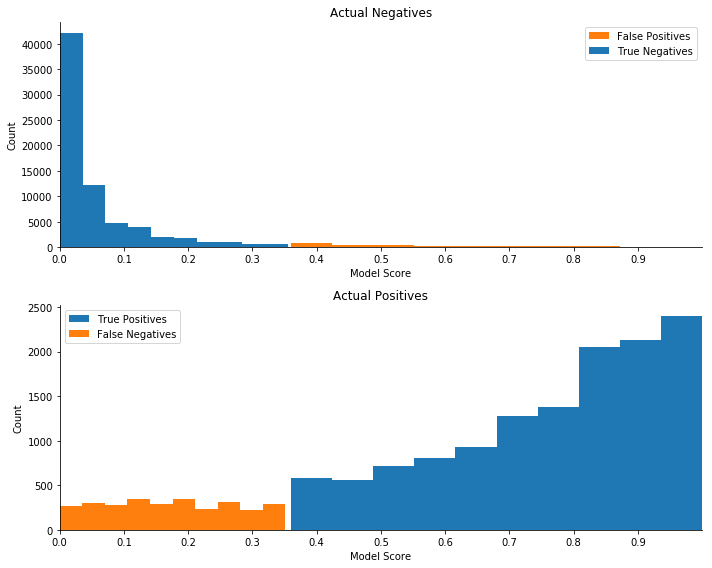

In [76]:
helpers.custom_pred_distro(positives=random_forest_positives, negatives=random_forest_negatives, cutoff=optimal_threshold, title=None)

The plot shows that the optimal threshold is below 0.5 and to the left of the bulk of the actual positives. The threshold seems to be at the point where the rate of change of true negatives as the threshold increases is slowing and the rate of change of false negatives is speeding up. The automatic model tuning job seems to have chosen a threshold that balances the two rates of change. To better understand the choice of optimal threshold, we would need to dig deeper into the portfolio value calculation and understand the costs and benefits associated with a change in threshold.

#### Determining maximum portfolio value

The following graphs plot the output of the automatic model tuning job. That is, they plot the portfolio value (on the y-axis) given a specific threshold (on the x-axis). Each point on a plot represents the outcome of a single training job from the overall automatic model tuning job. Recall that the goal is to find the classification threshold that optimizes the overall portfolio value. In each plot, the optimal threshold is the vertical, orange line.

The graph on the far left plots all 200 training job outcomes. The middle graph plots the top 100 training jobs as ranked by portfolio value; and the far right graph plots the top 100 training jobs as ranked by portfolio value.

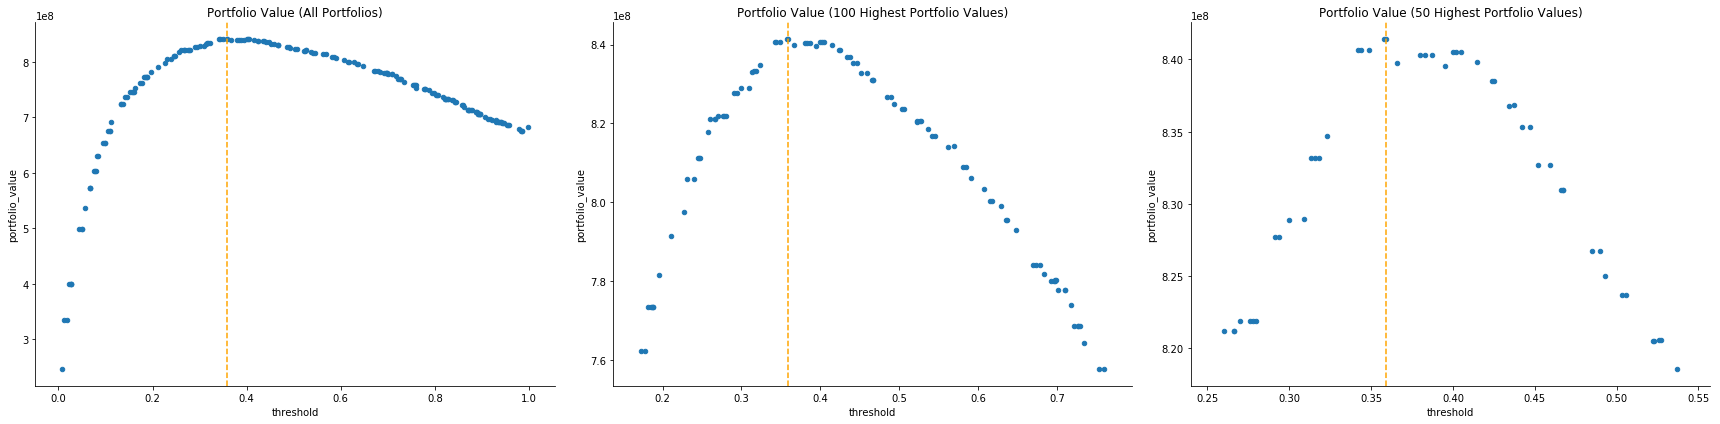

In [77]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))

hpo.plot.scatter(x='threshold', y='portfolio_value', ax=axes[0])
axes[0].axvline(optimal_threshold, linestyle='--', color='orange')
axes[0].set(title='Portfolio Value (All Portfolios)')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

hpo.sort_values(by='portfolio_value', ascending=False)[:100].plot.scatter(x='threshold', y='portfolio_value', ax=axes[1])
axes[1].axvline(optimal_threshold, linestyle='--', color='orange')
axes[1].set(title='Portfolio Value (100 Highest Portfolio Values)')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

hpo.sort_values(by='portfolio_value', ascending=False)[:50].plot.scatter(x='threshold', y='portfolio_value', ax=axes[2])
axes[2].axvline(optimal_threshold, linestyle='--', color='orange')
axes[2].set(title='Portfolio Value (50 Highest Portfolio Values)')
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)

plt.tight_layout()

Interestingly, the magnitude of the rate of change as we increase the threshold beyond its optimum value is generally much lower than the magnitude of the rate of change as we increase the threshold from 0 to its optimal value. This asymmetry is due to the SBA guarantee. The guarantee limits the downside risk that the lender takes on as she loosens her borrowing standards. If the SBA guarantee were not in place, we would expect the right side of this graph to decrease much more steeply.

Looking at the right two graphs, we zoom in on the peak of the curve and see that it is more symmetric around the optimal threshold. Something else to note is that the curve is not strictly decreasing after the optimal threshold; at times, the curve increases briefly. 

In [78]:
random_forest_max_portfolio_value = hpo.sort_values(by='portfolio_value', ascending=False).iloc[0,:]['portfolio_value']

In [79]:
print('Naive Portfolio Value (Threshold=0.5):  ${:0,.0f}'.format(naive_max_portfolio_value).replace('$-','-$'))
print('Random Forest Portfolio Value (Threshold=0.5): ${:0,.0f}'.format(random_forest_portfolio_value_point_five).replace('$-','-$'))
print('Random Forest Portfolio Value (Optimal Threshold={}): ${:0,.0f}'.format(optimal_threshold, random_forest_max_portfolio_value).replace('$-','-$'))

Naive Portfolio Value (Threshold=0.5):  $203,498,022
Random Forest Portfolio Value (Threshold=0.5): $823,674,285
Random Forest Portfolio Value (Optimal Threshold=0.359): $841,421,888


The top portfolio value returned from the random forest model with an optimized threshold is higher than both that generated by the naive model and by the random forest model with a 0.5 threshold. The increased portfolio value by adjusting the threshold is $17.7M, or 2.1\%—a substantial increase in potential return.

Interestingly, the optimal threshold is less than 0.5, so the lender can increase the overall value of her portfolio by decreasing the credit risk of the loans in the portfolio (by decreasing the threshold). If the lender had used a 0.5 threshold (the typical default value), she would likely have created a portfolio likely with more credit risk and lower portfolio value. If the SBA guarantee were not in place for these loans, the portfolio value at a threshold of 0.5 would likely have been much lower. 

#### Return associated with maximum portfolio value

This section shifts from focusing on the dollar return of the portfolio to the percentage return. The following set of graphs is similar to the previous set except that the graphs plot the net return on the portfolio associated with each of the 200 training jobs in the automatic model tuning run. The orange, vertical line is again the optimal threshold—optimal in the sense of maximizing portfolio value, not portfolio return—and the x-axis is the threshold. The y-axis is the portfolio return.

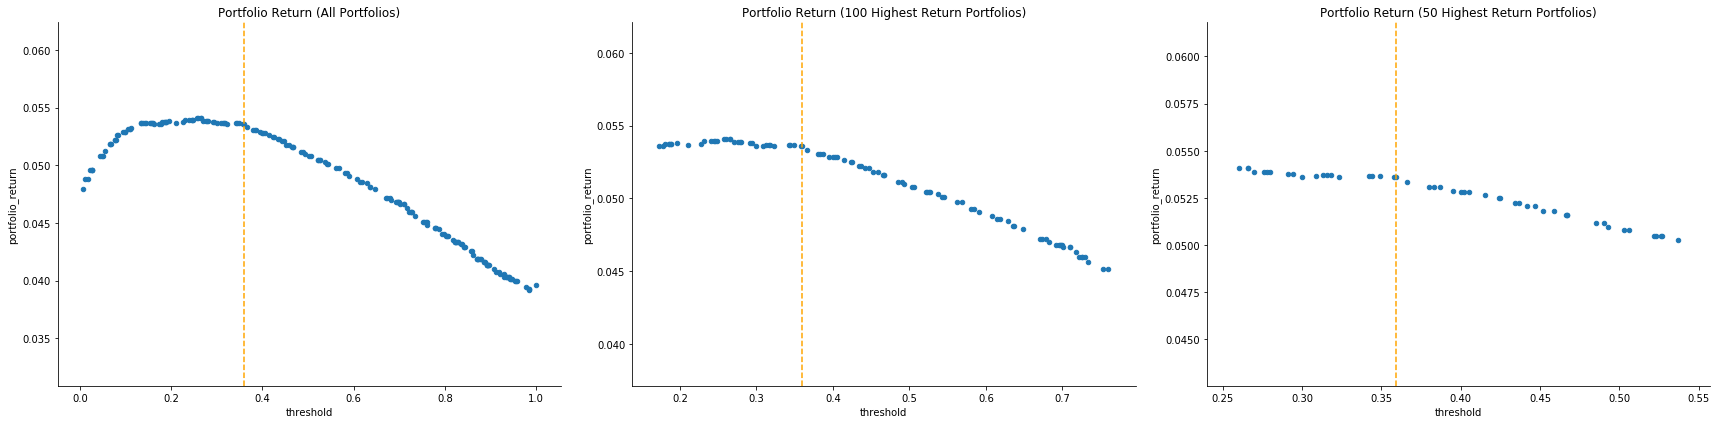

In [80]:
fig, axes = plt.subplots(1,3, figsize=(24, 6))

hpo.plot.scatter(x='threshold', y='portfolio_return', ax=axes[0])
axes[0].axvline(optimal_threshold, linestyle='--', color='orange')
axes[0].set(title='Portfolio Return (All Portfolios)')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

hpo.sort_values(by='portfolio_value', ascending=False)[:100].plot.scatter(x='threshold', y='portfolio_return', ax=axes[1])
axes[1].axvline(optimal_threshold, linestyle='--', color='orange')
axes[1].set(title='Portfolio Return (100 Highest Return Portfolios)')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

hpo.sort_values(by='portfolio_value', ascending=False)[:50].plot.scatter(x='threshold', y='portfolio_return', ax=axes[2])
axes[2].axvline(optimal_threshold, linestyle='--', color='orange')
axes[2].set(title='Portfolio Return (50 Highest Return Portfolios)')
axes[2].spines['right'].set_visible(False)
axes[2].spines['top'].set_visible(False)

plt.tight_layout()

From left to right, these graphs plot all 200 training job outcomes, the top 100 outcomes (based upon portfolio values), and the top 50 outcomes (based upon portfolio values). These return curves are much flatter than the portfolio value curves in the previous set of graphs. This is because the lender actively set interest rates on each of the loans she extends so that the return on the overall portfolio is expected to be about 5%. Additionally, note that the optimal threshold does not mark the peak in portfolio return. This is because, when maximizing portfolio value, it doesn’t matter whether adding more loans increases the percentage return on the portfolio, only that adding more loans adds to the dollar return on the portfolio. We can add lower percentage return loans to the portfolio and still add positive value in dollar terms, and that is what we are attempting to maximize.

The following output shows the results of calculating the return:

In [81]:
print('Naive Model Portfolio Return (Threshold=0.5): {:0,.3f}'.format(naive_portfolio_value_obj[0]/naive_portfolio_value_obj[1]))
print('Random Forest Portfolio Return (Threshold=0.5): {:0,.3f}'.format(random_forest_portfolio_value_point_five_obj[0]/random_forest_portfolio_value_point_five_obj[1]))
print('Random Forest Portfolio Return (Optimal Threshold={}): {:0,.3f}'.format(optimal_threshold, hpo.sort_values(by='portfolio_value', ascending=False).iloc[0,:]['portfolio_return']))  

Naive Model Portfolio Return (Threshold=0.5): 0.012
Random Forest Portfolio Return (Threshold=0.5): 0.051
Random Forest Portfolio Return (Optimal Threshold=0.359): 0.054


Likewise, the portfolio return from the random forest model with an optimized threshold is much higher than that generated by the naive model, though the returns from the two random forest models are similar. This is because in both of those models, the lender can set borrower-specific interest rates to compensate for borrower-specific levels of credit risk. If the threshold increases and higher risk loans enter the portfolio, the lender can set higher interest rates on those loans and on average keep her return the same.

## Adjusting the optimal threshold based upon additional business considerations<a id='adjustment'></a> 

Now we investigate how to determine if we should make marginal adjustments to the optimal threshold. Why would we want to adjust the optimal threshold calculated above? There may be certain idiosyncratic goals that a lender would like to achieve that are not captured by a generic portfolio value calculation. For example, a lender may want to maximize her portfolio value while also placing emphasis on lending to a certain sector of the economy or to a certain subgroup of the overall population. Adding this additional constraint to the portfolio value calculation itself may be difficult, if not impossible; whereas tackling these problem in two steps -- finding the generic optimum and then adjusting that optimum based upon idiosyncratic preferences -- is likely much easier and much more intuitive of a calculation.

As an example, say that the lender would like to extend more credit to the Construction sector of the economy. She wishes to determine if she should increase the optimal threshold to achieve this goal. Essentially she needs to determine the price she is willing to pay to include one more Construction sector loan in the portfolio, and the effect on portfolio value of including that loan. If the price is greater than the cost, then she should increase the threshold.

More specifically, to answer the question of whether the lender should increase the threshold by 0.01 (the smallest increment possible in our case), she needs to do the following:
1. Determine the price P that she is willing to pay for each additional Construction loan.
1. Calculate the decrease in portfolio value resulting from increasing the threshold by 0.01.  
1. Calculate the number of Construction sector loans added to the portfolio when the threshold is increased.  
1. Calculate the average cost of each additional Construction loan by dividing the change in portfolio value by number of Construction loans added to the portfolio. This is the mean cost C of each additional Construction loan in dollar terms.  
1. Compare price P that lender is willing pay for each additional Construction to the cost C that must actually be paid for each additional Construction loan.  
    5.1 If P >= -C, increase the threshold by 0.01.  
    5.2 Otherwise, keep threshold as is.
1. Continue to iterate on steps 2 to 5 above, until it is no longer advantageous to increase the threshold.
    


##### Step 1: Determine lender's willingness-to-pay

The lender must first determine the amount of portfolio value she is willing to forfeit for each additional Construction sector loan. Asssume the lender's willing-to-pay P in this case is $75,000.

In [82]:
P = 75000

##### Step 2: Determine decrease in portfolio value

Now the lender must calculate the portfolio value at the optimal threshold and the next highest threshold value, and then calculate the difference to determine how much portfolio value decreases as she increases the threshold by the minimum unit.

In [83]:
minimum_threshold_adjustment = .01 #minimum since 100 decision trees in Random Forest model

print('Optimal Threshold: {}'.format(optimal_threshold))
print('Optimal Threshold plus Minimum Increase: {}'.format(optimal_threshold + minimum_threshold_adjustment))

Optimal Threshold: 0.359
Optimal Threshold plus Minimum Increase: 0.369


Creating Boolean masks to subset the test data into groups that are incrementally included as the classification is increased.

In [84]:
approved_mask = random_forest_pred <= optimal_threshold
threshold_plus_one_mask = (random_forest_pred > optimal_threshold) & (random_forest_pred <= (optimal_threshold + minimum_threshold_adjustment))

Subsetting the loans in the test set into groups that are included as the threshold is increased by one, two, or three minimal units.

In [85]:
x_test_approved = x_test.reset_index(drop=True).loc[approved_mask,:]
x_test_plus_one = x_test.reset_index(drop=True).loc[threshold_plus_one_mask,:]

portfolio_value_change_by_threshold is total amount of portfolio value that must be given up to increase the threshold by .01.

In [86]:
hpo['threshold_2_digit'] = hpo['threshold'].astype('str').str[:4].astype('float')
portfolio_value_by_threshold = hpo.groupby('threshold_2_digit')['portfolio_value'].mean()
portfolio_value_change_by_threshold = portfolio_value_by_threshold.diff(periods=1)

##### Step 3: Determine increase in number of construction loans

Calculate the number of Construction sector loans that are added to the portfolio when the threshold is increased by 0.01.

In [87]:
construction_loan_increase = x_test_plus_one['NAICS_abbrev_23'].sum()

##### Step 4: Determine cost of each construction loan

In [88]:
threshold_plus_one = int(100*(optimal_threshold + minimum_threshold_adjustment))/100

print('Decrease in Portfolio Value: ${:0,.0f}'.format(portfolio_value_change_by_threshold[threshold_plus_one]).replace('$-','-$'))
print('Increase in Number of Construction Loans: {}'.format(construction_loan_increase))

Decrease in Portfolio Value: -$1,640,192
Increase in Number of Construction Loans: 26


In [89]:
C = portfolio_value_change_by_threshold[threshold_plus_one]/construction_loan_increase

print('Cost of each Additional Construction Loan: ${:0,.0f}'.format(C).replace('$-','-$'))

Cost of each Additional Construction Loan: -$63,084


##### Step 5: Compare cost to willingness-to-pay

If P is greater than/equal to -C, then move the threshold

In [107]:
print("Is the lender's willingness-to-pay, which is equal to ${:0,.0f}, greater than cost of an additional Construction loan, which is equal to ${:0,.0f}?".format(P, -C))
if (P > -C): 
    print('Yes, so the lender should increase the threshold.')
else:
    print('No, so the lender should not increase the threshold.')

Is the lender's willingness-to-pay, which is equal to $75,000, greater than cost of an additional Construction loan, which is equal to $63,084?
Yes, so the lender should increase the threshold.


The lender would not stop with this one step. She would continue to ask if she should increase the threshold by another 0.01 and iterate through the above steps until she reaches a point at which she chooses not to increase the threshold.

We assume that the lender always has access to the required capital if her willingness-to-pay is greater than the cost of an additional Construction sector loan. If desired, we can include a capital budget W for the lender as well. This change would modify the final step so that the lender checks both if B >= -C and if there is a sufficient amount of capital remaining in W to cover the sum of the principal of the additional loans.

## Other model metrics

How do the Naive, Random Forest with 0.5 Threshold, and Random Forest with Optimal Threshold models compare according to the more traditional performance metrics, like accuracy, precision, and recall?

In [91]:
naive_positives = naive_pred[y_test.reset_index(drop=True)==1]
naive_negatives = naive_pred[y_test.reset_index(drop=True)==0]

In [92]:
report = {}
report['Naive Model'] = helpers.classification_report(naive_positives, naive_negatives, 0.5)
report['Random Forest Model (0.5 Threshold)'] = helpers.classification_report(random_forest_positives, random_forest_negatives, 0.5)
report['Random Forest Model (Optimal Threshold)'] = helpers.classification_report(random_forest_positives, random_forest_negatives, optimal_threshold)

In [93]:
pd.DataFrame(report).T

,Accuracy,Precision_0,Precision_1,Recall_0,Recall_1
Naive Model,0.822721,0.822721,NaN,1.000000,0.000000
Random Forest Model (0.5 Threshold),0.935302,0.944246,0.883336,0.979177,0.731683
Random Forest Model (Optimal Threshold),0.934975,0.960350,0.817026,0.960626,0.815937


The above table reports the accuracy, precision, and recall for all three models. According to this table, which model is the best? That question can't be answered unless we know the benefits and costs to the lender associated with each cell of the confusion matrix, that is, the benefits associated with the true positives and true negatives and the costs associated with the false positives and the false negatives.

It's clear from the above table that both Random Forest models strictly dominate the Naive model (assuming that the cost of a false positive isn't significantly larger than the cost of a false negative). Additionally there isn't a clear cut winner between the two Random Forest models. The answer depends upon the relative costs of misclassification to the lender. We know from the business context of the problem described in the introduction that there is a significantly higher cost associated with a false negative than with a false positive. Given that information, it is more valuable for the lender to minimize false negatives, and as such, Recall_1 or Precision_0 are the most salient metric. 

This discussion illustrates the fact that determining the so-called best model requires knowledge of the business use case that this ML model addresses, and the benefits and costs associated with each potential classification outcome; only then can we determine the metric that best captures what success means to the business. Additionally, precision and recall only include information about two of the four cells of the confusion matrix, but the lender cares about the net benefits associated with all four cells. Using these typical metrics ignores half of the outcomes that the lender cares about and also ignores the specific costs and benefits associated with all outcomes. Because of this, these metrics are lacking, and one should calculate a single problem-specific metric that incorporates the specific costs and benefits associated with all cells of the confusion matrix to determine the optimal threshold. In this post, this metric is portfolio value.

This optimization approach can be used more generally to test whether a threshold is optimal for the problem and data at hand.  

## Conclusion<a id='conclusion'></a>

This post showed how to find the optimal threshold in a binary classification problem. Specifically, we describe how to use Amazon SageMaker automatic model tuning to determine the classification threshold that maximizes the portfolio value of a lender when choosing which subset of borrowers to extend credit to. More generally, the method of choosing an optimal threshold we describe can be applied to situations in which you need to choose multiple thresholds. The main modification needed is to incorporate multiple thresholds into the problem-specific, threshold-based metric. After doing that, you could use Amazon SageMaker automatic model tuning to find a vector of thresholds, as opposed to a single threshold, that maximizes your metric.

The threshold determination approach we describe has several substantial advantages. First, it makes the logic and rationale used in determining a threshold explicit. Second, it requires the business to clearly state its cost matrix, based on the specific actions to take on the model predictions and their associated benefits and costs. Making the logic and cost structure explicitly can drive challenging discussions in the business, and force differing implicit decisions and valuations onto the table for open discussion and agreement.

Lastly, this approach can also potentially be used to address the issue of imbalanced data. The issue with imbalanced data is often not that one target class has a much larger representation in the data than another target class, it’s that the misclassification costs (that is, the cost of a false positive versus a false negative), are dramatically different from one another. Instead of using sampling to balance the training data, you can clearly define the misclassification costs in the problem-specific metric, and use that metric to find an optimal threshold. This approach makes the issue less a technical one of using a trick of modifying the distribution of data to more of a business one of clearly specifying the cost structure of a problem. That may address the true issue of imbalanced data more directly, which is the issue of imbalanced misclassification costs.

For any of your business use cases that requires setting a classification threshold, consider using Amazon SageMaker Automatic Model Tuning functionality and the method described here. To get started, open the [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker) and the [code](https://github.com/aws-samples/amazon-sagemaker-hyperparameter-tuning-portfolio-optimization/tree/master/hyperparameter-tuning-portfolio-optimization) used to generate the results in this post. If you have thoughts on business use cases this method can be applied to or any questions, please leave them in the comments.

For more information on training models that have asymmetric classification costs, see this [Training models with unequal economic error costs using Amazon SageMaker.](https://aws.amazon.com/blogs/machine-learning/training-models-with-unequal-economic-error-costs-using-amazon-sagemaker/). 

Copyright 2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.  
SPDX-License-Identifier: MIT-0